# LSTM

In [4]:
# imports
import time
import os
import optuna
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, balanced_accuracy_score, accuracy_score, precision_score, f1_score, recall_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from nltk.corpus import stopwords
import re
import nltk
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')

## 1. Data loading and exploration

In [5]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [6]:
ag_news_train_df.shape

(120000, 3)

In [7]:
ag_news_test_df.shape

(7600, 3)

In [8]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [9]:
amazon_reviews_df.shape

(17340, 4)

In [10]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [11]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

<AxesSubplot:>

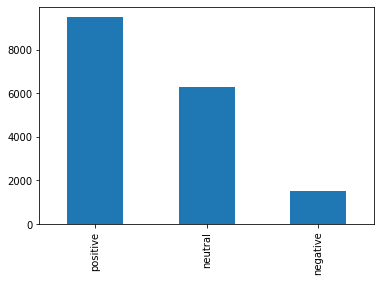

In [12]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

<AxesSubplot:>

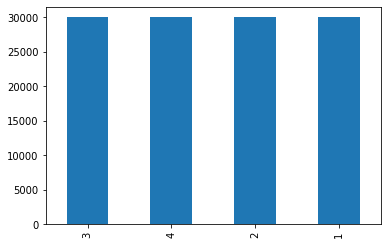

In [13]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <BarContainer object of 10 artists>)

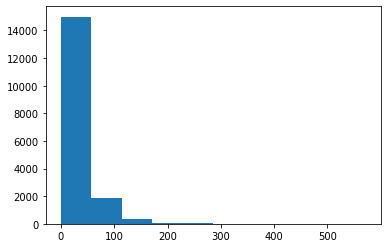

In [14]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

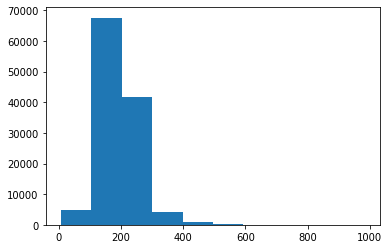

In [15]:
plt.hist(ag_news_train_df.Description.str.len())

In [16]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [17]:
amazon_reviews_df.dropna(inplace=True)

## 2. Train/Val/Test split

In [18]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [19]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [20]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.33)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [21]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [22]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [23]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [24]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.33)

In [25]:
# split the data sets accordignly, so we can perform hyperparameter tuning somewhat successfully

np.random.seed(42)
reviews_train_idx = np.random.choice(y_train_reviews.shape[0], 
                                     replace=False, size=y_train_reviews.shape[0]//2)
news_train_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//8)

X_train_reviews_half = X_train_reviews.iloc[reviews_train_idx,:]
y_train_reviews_half = y_train_reviews.iloc[reviews_train_idx]
X_train_news_eight = X_train_news.iloc[news_train_idx]
y_train_news_eight = y_train_news.iloc[news_train_idx]

In [26]:
# checking if models are saved

best_model_nn_reviews_is_saved = os.path.exists('models/best_model_lstm_reviews.sav')
best_model_nn_news_is_saved = os.path.exists('models/best_model_lstm_news.sav')

## 3. Model development - LSTM

### 3.1. Reviews data set

In [27]:
# setting the vocabulary and sentence length
voc_size = 5000
sent_length = 40
embedding_vector_features = 40

In [41]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

In [42]:
def preprocessing_reviews(X, y, sent_length):
    X.drop(['cleaned_review_length', 'review_score'], axis=1, inplace=True)
    corpus = X['cleaned_review'].values.tolist()
    onehot_repr = [one_hot(words, voc_size) for words in corpus] 
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)
        
    y = pd.get_dummies(y)
    
    X = np.array(embedded_docs)
    y = np.array(y)
    
    return (X, y)

In [43]:
X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

#### 3.1.1. Reviews, LSTM model 1. - base

In [45]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 40)            200000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 256,703
Trainable params: 256,703
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 3, batch_size = 100)

Epoch 1/3
93/93 [==============================] - 9s 69ms/step - loss: 0.8318 - accuracy: 0.6134 - val_loss: 0.6387 - val_accuracy: 0.7144
Epoch 2/3
93/93 [==============================] - 6s 63ms/step - loss: 0.5192 - accuracy: 0.7868 - val_loss: 0.4963 - val_accuracy: 0.7907
Epoch 3/3
93/93 [==============================] - 6s 64ms/step - loss: 0.3976 - accuracy: 0.8469 - val_loss: 0.4746 - val_accuracy: 0.8025


The results show that the model is overfitting the training data and not generalizing well to the validation data. This can be seen from the increasing difference between training accuracy and validation accuracy as the number of epochs increases.

The training accuracy increases up to 95.6% while the validation accuracy only reaches 82.15%. This suggests that the model is memorizing the training data rather than learning the underlying patterns that can be generalized to the validation set.

The loss is also decreasing on the training set, but increasing on the validation set. This further supports the overfitting issue.

To address the overfitting issue, we will try using regularization techniques like dropout, or simplifying the model architecture.

In [47]:
y_pred = model.predict(X_test)

# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

accuracy_score(y_test,y_pred)

0.8102652825836217

In [48]:
precision_score(y_test,y_pred, average='weighted')

0.8033121576655468

In [49]:
recall_score(y_test,y_pred, average='weighted')

0.8102652825836217

In [50]:
f1_score(y_test,y_pred, average='weighted')

0.8048552495126284

The test accuracy is 0.827 which is very similar to the validation results, therefore we will try to add dropout layers, or simplify the model architecture.

We are using accuracy at the moment, we will later on focus on more metrics, and see in greated details how to best optimize the model.

#### 3.1.2. Reviews, LSTM model 2. - base with dropout

In [51]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 40, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 256,703
Trainable params: 256,703
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 3, batch_size = 100)

Epoch 1/3
93/93 [==============================] - 9s 69ms/step - loss: 0.8359 - accuracy: 0.6067 - recall: 0.4307 - precision: 0.6682 - val_loss: 0.6114 - val_accuracy: 0.7330 - val_recall: 0.6679 - val_precision: 0.7853
Epoch 2/3
93/93 [==============================] - 6s 59ms/step - loss: 0.5383 - accuracy: 0.7779 - recall: 0.7245 - precision: 0.8218 - val_loss: 0.5005 - val_accuracy: 0.7907 - val_recall: 0.7463 - val_precision: 0.8297
Epoch 3/3
93/93 [==============================] - 6s 60ms/step - loss: 0.4250 - accuracy: 0.8318 - recall: 0.8049 - precision: 0.8529 - val_loss: 0.5020 - val_accuracy: 0.7977 - val_recall: 0.7702 - val_precision: 0.8198


In [53]:
y_pred = model.predict(X_test)

# adjust the y_pred and the y_test

y_pred = np.argmax(y_pred, axis = 1)
# y_test = np.argmax(y_test, axis = 1)

accuracy_score(y_test, y_pred)

0.7987312572087658

In [54]:
precision_score(y_test,y_pred, average='weighted')

0.8017900097023084

In [55]:
recall_score(y_test,y_pred, average='weighted')

0.7987312572087658

In [56]:
f1_score(y_test,y_pred, average='weighted')

0.7978194987059796

After adding two dropout layers with the probability of 0.3, we get an accuracy of 0.828 which isn't an improvement really. We will now try to change the model architecture, and see what we can get.

We will change the voc_size and the sent_length to see if that can make the results better.

#### 3.1.3. Reviews, LSTM model 3. - dropout and voc and sent length changed

In [57]:
# setting the vocabulary and sentence length
voc_size = 10000
sent_length = 100
embedding_vector_features = 60

In [58]:
X_train = X_train_reviews.copy()
y_train = y_train_reviews.copy()
X_test = X_test_reviews.copy()
y_test = y_test_reviews.copy()
X_valid = X_valid_reviews.copy()
y_valid = y_valid_reviews.copy()

X_train, y_train = preprocessing_reviews(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_reviews(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_reviews(X_test, y_test, sent_length)

In [59]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 60)           600000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              128800    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 3)                 603       
                                                                 
Total params: 729,403
Trainable params: 729,403
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 3, batch_size = 64)

Epoch 1/3
146/146 [==============================] - 36s 224ms/step - loss: 0.7166 - accuracy: 0.6784 - val_loss: 0.6435 - val_accuracy: 0.6991
Epoch 2/3
146/146 [==============================] - 39s 268ms/step - loss: 0.4565 - accuracy: 0.8206 - val_loss: 0.4406 - val_accuracy: 0.8217
Epoch 3/3
146/146 [==============================] - 40s 273ms/step - loss: 0.3208 - accuracy: 0.8769 - val_loss: 0.4264 - val_accuracy: 0.8340


In [61]:
y_pred = model.predict(X_test)

# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
# y_test = np.argmax(y_test, axis = 1)

accuracy_score(y_test,y_pred)

0.8434256055363322

In [62]:
precision_score(y_test,y_pred, average='weighted')

0.8419363818230585

In [63]:
recall_score(y_test,y_pred, average='weighted')

0.8434256055363322

In [64]:
f1_score(y_test,y_pred, average='weighted')

0.8360578757043483

The best result is 84 % accuracy, which is an improvement, it mostly happened because we increased the size of the features, and the sent length, and the voc size, so it managed to capture more information. Of, course it does train longer than but that is the trade off we must accept.

#### 3.1.2. Reviews, Hyperparameter tuning

In [66]:
def create_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=hp.Int('voc_size', 5000, 20000, step=2500),
        output_dim=hp.Int('embedding_size', 32, 128, 32),
        input_length = 40))    
    model.add(Bidirectional(LSTM(units=hp.Int('LSTM_units', 32, 128, 32))))
    model.add(Dense(units=hp.Int('dense_units', 10, 50, 10), activation=hp.Choice('dense_activation', values=['relu', 'sigmoid', 'tanh'])))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss=CategoricalCrossentropy(),
        metrics=[Accuracy()]
    )
    return model

In [67]:
tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='movie_review_sentiment_analysis'
)

INFO:tensorflow:Reloading Tuner from my_dir\movie_review_sentiment_analysis\tuner0.json


In [69]:
tuner.search(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

INFO:tensorflow:Oracle triggered exit


In [70]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hyperparameters)

In [74]:
best_hyperparameters

In [71]:
start_time = time.time()

model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

end_time = time.time()

reviews_train_time = end_time - start_time

Epoch 1/3


ValueError: in user code:

    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 40), found shape=(None, 100)


In [ ]:
start_time = time.time()

y_pred = model.predict(X_test)

# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

accuracy_score(y_test,y_pred)

end_time = time.time()

reviews_test_time = end_time - start_time

In [ ]:
precision_score(y_test,y_pred, average='weighted')

In [ ]:
recall_score(y_test,y_pred, average='weighted')

In [ ]:
f1_score(y_test,y_pred, average='weighted')

Best model is, explain the best parameters and stuff.

### 3.2. News data set

In [55]:
# get the average size of sentences

# i=0
# length = 0
# for x in X_train:
#     length += len(x)
#     i = i+1
    
# print(length/i)"""

In [62]:
### helper functions

# Tokenize the sentence into words
lemmatizer = WordNetLemmatizer()

def lemmetize_it(sentence):
    words = nltk.word_tokenize(sentence)
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    lemmas_str = ' '.join(lemmas)
    return lemmas_str

def clean_news_data(X):    
    X = X.apply(lambda x: " ".join(x.lower() for x in x.split()))
    X = X.str.replace('[^\w\s]','', regex=True)
    
    stop = stopwords.words('english')
    X = X.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    # Create a WordNet lemmatizer object
    lemmatizer = WordNetLemmatizer()
    
    X = X.apply(lemmetize_it)
    
    return(X)

def preprocessing_news(X, y, sent_length):
    corpus = X.values.tolist()
    onehot_repr = [one_hot(words, voc_size) for words in corpus] 
    embedded_docs = pad_sequences(onehot_repr, padding = 'pre', maxlen = sent_length)
        
    y = pd.get_dummies(y)
    
    X = np.array(embedded_docs)
    y = np.array(y)
    
    return (X, y)

In [63]:
X_train = X_train_news_eight.copy()
y_train = y_train_news_eight.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

### 3.2.1. News, LSTM model 1 - base

In [64]:
# setting the vocabulary and sentence length
voc_size = 10000
sent_length = 150
embedding_vector_features = 50

In [65]:
X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_news(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [66]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 50)           500000    
                                                                 
 lstm_4 (LSTM)               (None, 100)               60400     
                                                                 
 dense_4 (Dense)             (None, 4)                 404       
                                                                 
Total params: 560,804
Trainable params: 560,804
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 3, batch_size = 100)

Epoch 1/3
101/101 [==============================] - 55s 524ms/step - loss: 1.1401 - accuracy: 0.5549 - val_loss: 0.7634 - val_accuracy: 0.7701
Epoch 2/3
101/101 [==============================] - 66s 660ms/step - loss: 0.4658 - accuracy: 0.8684 - val_loss: 0.4197 - val_accuracy: 0.8655
Epoch 3/3
101/101 [==============================] - 66s 659ms/step - loss: 0.2482 - accuracy: 0.9268 - val_loss: 0.4056 - val_accuracy: 0.8681


Based on the provided results of the LSTM model, it appears to be a good starting point for the news classification task. The training accuracy increased with each epoch, while the validation accuracy remained consistently high, suggesting that the model is generalizing well to new data. The validation loss did not increase significantly over the three epochs, indicating that the model is not overfitting. Overall, the model achieved an accuracy of 85.5% on the validation data.

In [68]:
y_pred = model.predict(X_test)

# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

accuracy_score(y_test,y_pred)

0.8692105263157894

In [69]:
precision_score(y_test,y_pred, average='weighted')

0.8685147199313861

In [70]:
recall_score(y_test,y_pred, average='weighted')

0.8692105263157894

In [71]:
f1_score(y_test,y_pred, average='weighted')

0.8686674546518696

The test accuracy is 86.9% which is very similar to the validation results, therefore we will try to add dropout layers, or simplify the model architecture.

#### 3.2.2. News, LSTM model 2. - base with dropout

In [72]:
# setting the vocabulary and sentence length
voc_size = 10000
sent_length = 150
embedding_vector_features = 50

In [73]:
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 50)           500000    
                                                                 
 dropout_2 (Dropout)         (None, 150, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 404       
                                                                 
Total params: 560,804
Trainable params: 560,804
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 3, batch_size = 100)

Epoch 1/3
101/101 [==============================] - 61s 589ms/step - loss: 1.1741 - accuracy: 0.4965 - val_loss: 0.9604 - val_accuracy: 0.6744
Epoch 2/3
101/101 [==============================] - 73s 722ms/step - loss: 0.6062 - accuracy: 0.8048 - val_loss: 0.4312 - val_accuracy: 0.8547
Epoch 3/3
101/101 [==============================] - 81s 802ms/step - loss: 0.2847 - accuracy: 0.9103 - val_loss: 0.4444 - val_accuracy: 0.8474


In [76]:
y_pred = model.predict(X_test)

# adjust the y_pred and the y_test

y_pred = np.argmax(y_pred, axis = 1)
# y_test = np.argmax(y_test, axis = 1)

accuracy_score(y_test, y_pred)

0.8506578947368421

In [77]:
precision_score(y_test,y_pred, average='weighted')

0.8545427550882603

In [78]:
recall_score(y_test,y_pred, average='weighted')

0.8506578947368421

In [79]:
f1_score(y_test,y_pred, average='weighted')

0.8499309758025632

After adding two dropout layers with the probability of 0.3, we get an accuracy of 83.9% which isn't an improvement really. We will now try to change the model architecture, and see what we can get. We will change the voc_size and the sent_length to see if that can make the results better, same as in the first example.

#### 3.1.3. LSTM model 3. - dropout and voc and sent length changed

In [80]:
# setting the vocabulary and sentence length
voc_size = 20000
sent_length = 200
embedding_vector_features = 100

In [81]:
X_train = X_train_news_eight.copy()
y_train = y_train_news_eight.copy()
X_test = X_test_news.copy()
y_test = y_test_news.copy()
X_valid = X_valid_news.copy()
y_valid = y_valid_news.copy()

X_train = clean_news_data(X_train)
X_valid = clean_news_data(X_valid)
X_test = clean_news_data(X_test)

X_train, y_train = preprocessing_news(X_train, y_train, sent_length)
X_valid, y_valid = preprocessing_news(X_valid, y_valid, sent_length)
X_test, y_test = preprocessing_news(X_test, y_test, sent_length)

In [82]:
# creating the base LSTM model

model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(4, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 100)          2000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 4)                 804       
                                                                 
Total params: 2,161,604
Trainable params: 2,161,604
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 3, batch_size = 64)

Epoch 1/3
158/158 [==============================] - 239s 1s/step - loss: 0.7839 - accuracy: 0.6894 - val_loss: 0.3973 - val_accuracy: 0.8706
Epoch 2/3
158/158 [==============================] - 210s 1s/step - loss: 0.2365 - accuracy: 0.9306 - val_loss: 0.3814 - val_accuracy: 0.8719
Epoch 3/3
158/158 [==============================] - 199s 1s/step - loss: 0.1183 - accuracy: 0.9694 - val_loss: 0.4245 - val_accuracy: 0.8647


In [84]:
y_pred = model.predict(X_test)

# adjust the y_pred and the y_test
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

accuracy_score(y_test,y_pred)

0.8717105263157895

In [85]:
precision_score(y_test,y_pred, average='weighted')

0.870931753675252

In [86]:
recall_score(y_test,y_pred, average='weighted')

0.8717105263157895

In [87]:
f1_score(y_test,y_pred, average='weighted')

0.8710507512476183

In [88]:
# best result is 87 % accuracy without hyperparameter tuning

## 4. Final results

| Data set | Accuracy | Precision | Recall | F1 |
| --- | --- | --- | --- | --- |
| Amazon Reviews | 0.0 | 0.0 | 0.0 | 0.0 |
| AG News | 0.0 | 0.0 | 0.0 | 0.0 |

Metrics: Accuracy, Precision, Recall, F1  
Runtime comparison: Training, Testing time

Compare not just the overall measures, but perform a detailed comparison and analysis per class
(confusion matrix), to identify if the two approaches lead to different types of errors in the different
classes, and also try to identify other patterns.

Also perform a detailed comparison of runtime, considering both time for training and testing,
including also the feature extraction components.

Ubaci odakle si kod uzimao.

● The main focus is on analysing the differences in traditional vs. deep learning.